### Bitcoin Prediction - Kaggle

In [1]:
#Installs kagglehub for dataset - uncomment if needed
#!pip install kagglehub
#!pip install prophet

# Imports libraries
import os
import requests
import json
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime

In [2]:
# Download latest version of dataset
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

# List Path & files 
print("Dataset downloaded to:", path)
print("Files:", os.listdir(path))

# Load the CSV create 2 dataframes
csv_file = os.path.join(path, "btcusd_1-min_data.csv")
data = pd.read_csv(csv_file)
df = pd.read_csv(csv_file)

# Prints head to confirm
print(data.head())

Dataset downloaded to: C:\Users\Devin Ferko\.cache\kagglehub\datasets\mczielinski\bitcoin-historical-data\versions\354
Files: ['btcusd_1-min_data.csv']
      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0


In [3]:
# Convert Timestamp to datetime
data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')

# Resampling to daily frequency
data.index = data.Timestamp
data = data.resample('D').mean()

# Resampling to monthly frequency
data_month = data.resample('ME').mean()

# Resampling to annual frequency
data_year = data.resample('YE-DEC').mean()

# Resampling to quarterly frequency
data_Q = data.resample('QE-DEC').mean()

# Prints head to confirm - Uncomment if needed
#data.head()
#data_month.head()
#data_year.head()
#data_Q.head()

##### We want to look at Volumne Weighted Average Price

What does the VWAP tell you?
VWAP is the abbreviation for volume-weighted average price, which is a technical analysis tool that shows the ratio of an asset's price to its total trade volume. It provides traders and investors with a measure of the average price at which a stock is traded over a given period of time.

In [4]:
# Calculates Weighted Value

data['Weighted_Price'] = (data['High'] + data['Low'] + data['Close']) / 3


In [5]:
# Calculates VWAP
vwap = data['Weighted_Price'] * data['Volume']

# Resamples to the specific frequencies - Daily, Monthly, Yearly, Quarterly - We then want to sum the VWAP and divide by the sum of the volume for each period
vwap_d = vwap.resample('D').sum() / data['Volume'].resample('D').sum()
vwap_m = vwap.resample('ME').sum() / data['Volume'].resample('ME').sum()
vwap_y = vwap.resample('YE-DEC').sum()  / data['Volume'].resample('YE-DEC').sum()
vwap_q = vwap.resample('QE-DEC').sum()  / data['Volume'].resample('QE-DEC').sum()

# Amends to DataFrame based on frequency
data = vwap_d.to_frame(name='Weighted Price')
data_month = vwap_m.to_frame(name='Weighted Price')
data_year = vwap_y.to_frame(name='Weighted Price')
data_Q = vwap_q.to_frame(name='Weighted Price')

# Prints head to confirm - Comment if needed
#data.head()
#data_month.head()
#data_year.head()
#data_Q.head()

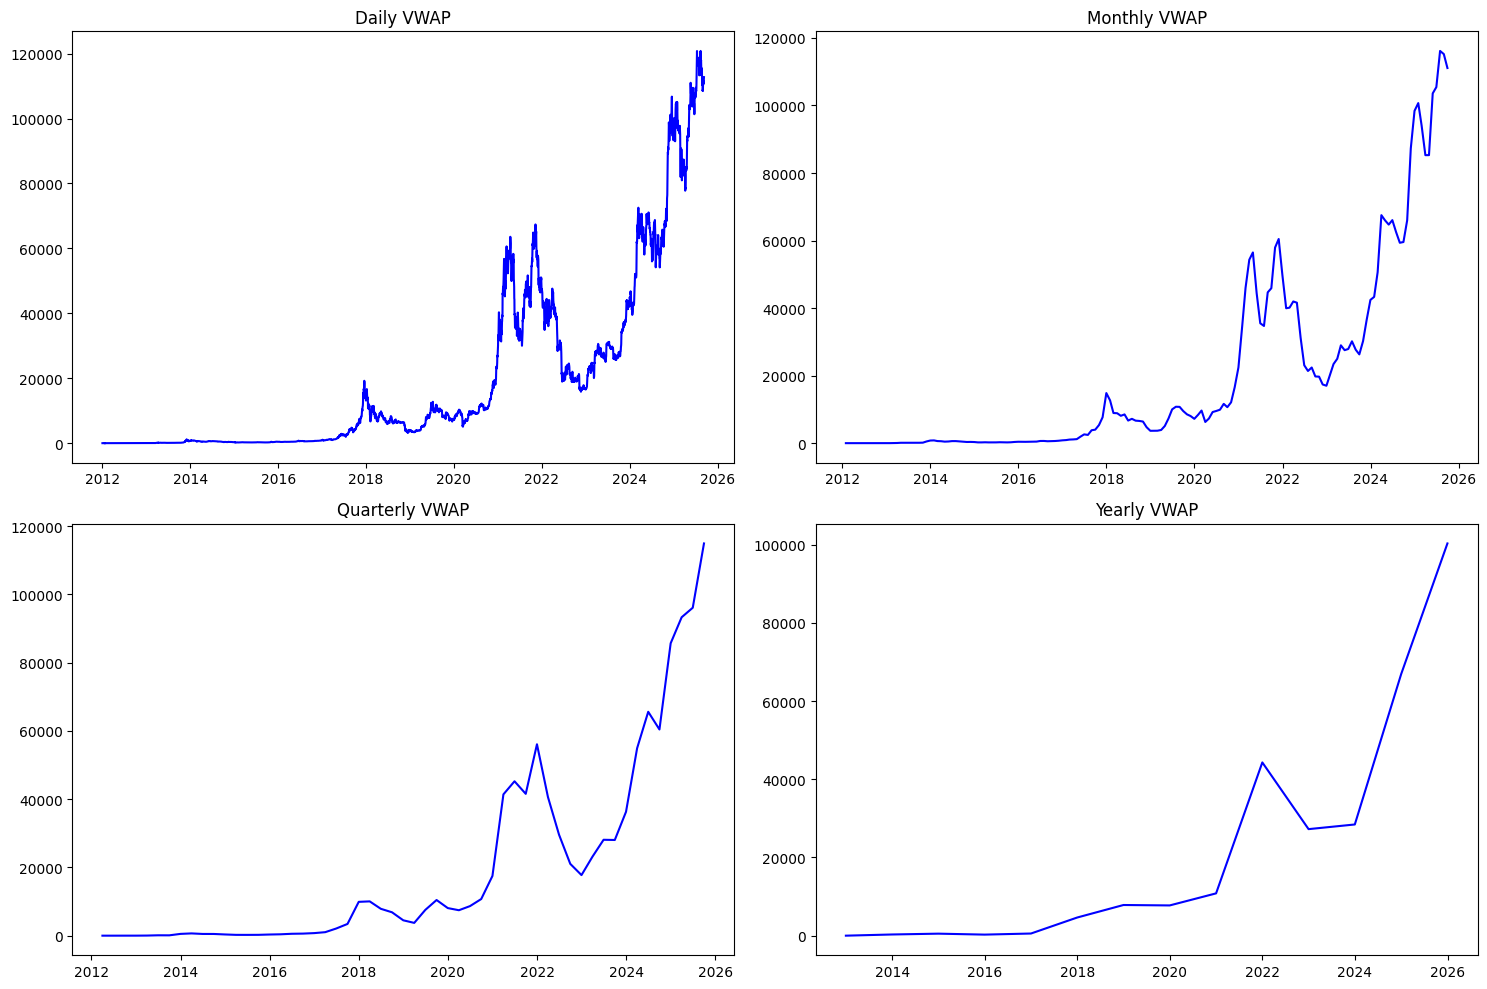

In [6]:
# Plot the above data to visualize trends

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Daily
axs[0,0].plot(data.index, data['Weighted Price'], color='blue')
axs[0,0].set_title('Daily VWAP')

# Monthly
axs[0,1].plot(data_month.index, data_month['Weighted Price'], color='blue')
axs[0,1].set_title('Monthly VWAP')

# Yearly
axs[1,0].plot(data_Q.index, data_Q['Weighted Price'], color='blue')
axs[1,0].set_title('Quarterly VWAP')

# Quarterly
axs[1,1].plot(data_year.index, data_year['Weighted Price'], color='blue')
axs[1,1].set_title('Yearly VWAP')

plt.tight_layout()
plt.show()


# Prediction Model

After a bit of research I decide to implentent a hybrid model.
    - Prophet - captures long-term trend + seasonality.
    - XGBoost - models short-term residuals that Prophet misses.

In [7]:
# Prophet Prediction Model

#convert timestamp to datetime then set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)

# Daily Frequency
df_prophet = df[['Close']].resample('D').ffill().reset_index()
df_prophet = df_prophet.rename(columns={'Timestamp': 'ds', 'Close': 'y'})
df_prophet['y'] = np.log(df_prophet['y'])  # Log transform to stabilize variance

# Prophet model

model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(df_prophet)

# Forecasting for 180 days - essentially 6 months
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)



# Saves Prophet Baseline and calculates Residuals 

# Line 1 Prophet Baseline
# Prophet creates a yhat column in the forecast dataframe
# But used for predicting future values so dateframe won't line up with original df_prophet
# Example df is 100 row, after prophet df is 120 rows
# Therefore ':len(df_prophet)-1' evens out to the correct number of rows
df_prophet['prophet_yhat'] = forecast.loc[:len(df_prophet)-1, 'yhat'].values

# Line 2 Residuals
# Residuals is actual value minus predicted value
# Used to judge the accuracy of the model by how far off your predictions were
df_prophet['residuals'] = df_prophet['y'] - df_prophet['prophet_yhat']

df_prophet.head()

10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing


,ds,y,prophet_yhat,residuals
0,2012-01-01,NaN,1.647174,NaN
1,2012-01-02,1.576915,1.646589,-0.069674
2,2012-01-03,1.609438,1.651865,-0.042428
3,2012-01-04,1.665818,1.656024,0.009794
4,2012-01-05,1.717395,1.659172,0.058223


Text(0.5, 1.0, 'Prophet Model: Actual vs Predicted')

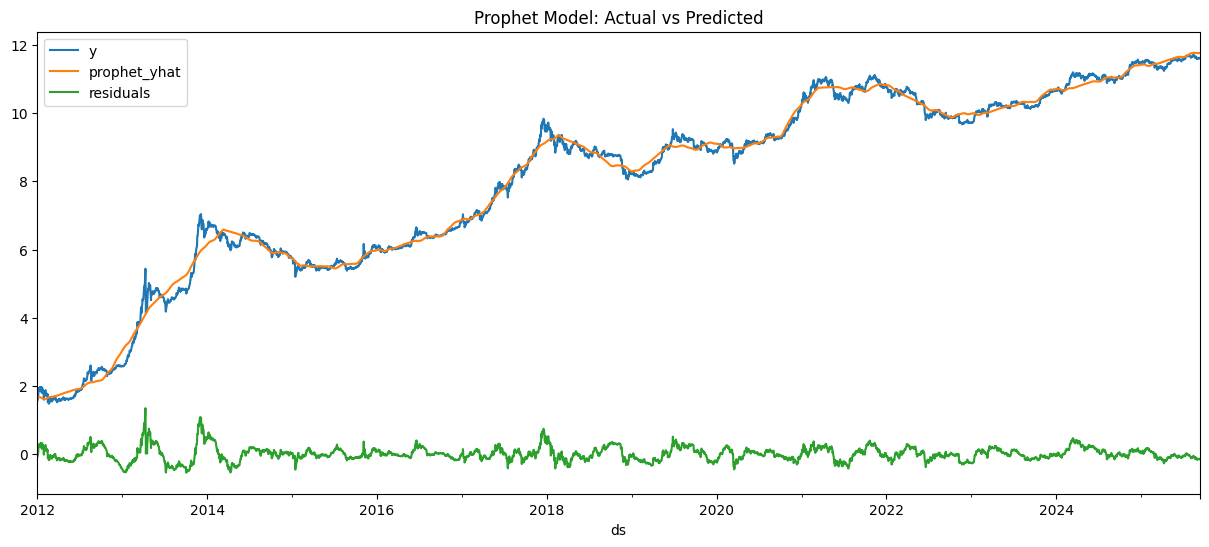

In [8]:
# Plot values against dates
plot = df_prophet.plot(x= 'ds', y= ['y', 'prophet_yhat', 'residuals'], figsize=(15, 6))


plt.title('Prophet Model: Actual vs Predicted')

##### Notes on the Above:

- The Prophet model aligns closely with the actual values, indicating a generally good fit. Notably, the residuals appear to “flatten” over time, suggesting the model achieves greater accuracy with later dates.

- The Prophet prediction line is relatively smooth compared to the raw actual values. This indicates the model is better suited for capturing long-term trends and seasonality rather than short-term daily fluctuations.

- The residuals mostly hover around zero without significant long-lasting bias, suggesting the model is not consistently over- or under-estimating the values.

- Periods of higher volatility in the actual data (e.g., sharp spikes and dips) correspond to larger residuals, showing that Prophet struggles most when the underlying series experiences sudden, short-term shocks.

- The model appears to adapt well to structural changes in the trend over time, but sharp turning points are lagged slightly in the forecast, which is typical of smoothing models.

In [ ]:
# Feature creation for XGBoost Model

# Creates lag features for residuals, by lag days of 1,2,3,7,14,30
def lag_features(df_prophet, col='residuals', lags=[1,2,3,7,14,30]):
    for lag in lags:
        df_prophet[f'{col}_lag_{lag}'] = df_prophet[col].shift(1)
    return df_prophet

# Creates rolling mean and std features for residuals, by windows of 7,14,30
def rolling_features(df_prophet, col='residuals', windows=[7,14,30]):
    for window in windows:
        df_prophet[f'{col}_mean_{window}'] = df_prophet[col].rolling(window=window).mean().shift(1)
        df_prophet[f'{col}_std_{window}'] = df_prophet[col].rolling(window=window).std().shift(1)
    return df_prophet

# Apply the functions to create features, drop NA values
df_prophet = lag_features(df_prophet)
df_prophet = rolling_features(df_prophet)
df_prophet = df_prophet.dropna()

# Check the head of the dataframe
df_prophet.head()

,ds,y,prophet_yhat,residuals,residuals_lag_1,residuals_lag_2,residuals_lag_3,residuals_lag_7,residuals_lag_14,residuals_lag_30,residuals_mean_7,residuals_std_7,residuals_mean_14,residuals_std_14,residuals_mean_30,residuals_std_30
31,2012-02-01,1.713798,1.612865,0.100933,0.107713,0.107713,0.107713,0.107713,0.107713,0.107713,0.148545,0.088452,0.209166,0.095157,0.197345,0.111923
32,2012-02-02,1.790091,1.613906,0.176185,0.100933,0.100933,0.100933,0.100933,0.100933,0.100933,0.126896,0.076515,0.196271,0.096824,0.203032,0.101761
33,2012-02-03,1.834180,1.611823,0.222357,0.176185,0.176185,0.176185,0.176185,0.176185,0.176185,0.128286,0.077437,0.186590,0.090992,0.210319,0.090816
34,2012-02-04,1.838961,1.611195,0.227766,0.222357,0.222357,0.222357,0.222357,0.222357,0.222357,0.129266,0.078755,0.191719,0.090828,0.217404,0.082547
35,2012-02-05,1.871802,1.611952,0.259850,0.227766,0.227766,0.227766,0.227766,0.227766,0.227766,0.139655,0.087079,0.186523,0.086082,0.223056,0.076883
